## Load library and define some functions needed

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import datetime as dt
import random

import json
import os.path
import gc

MODEL_FILE_NAME = 'model.txt'

In [2]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
songs_df = pd.read_csv('data/songs.csv')
song_extra_info_df = pd.read_csv('data/song_extra_info.csv')
members_df = pd.read_csv('data/members.csv')

In [3]:
def custom_cv(params, train_set, hold_out_set=None, k_fold=5, num_boost_round=20):
    x_train = train_set.data
    y_train = train_set.label
    n = x_train.shape[0]
    unit = n // k_fold

    cv_scores = []
    for k in range(k_fold):
        x_cv_valid = None
        y_cv_valid = None
        if k == k_fold - 1:
            x_cv_valid = x_train[unit * k:]
            y_cv_valid = y_train[unit * k:]
        else:
            x_cv_valid = x_train[unit * k: unit * (k + 1)]
            y_cv_valid = y_train[unit * k: unit * (k + 1)]

        x_cv_train = None
        y_cv_train = None
        if k == 0:
            x_cv_train = x_train[unit * (k + 1):]
            y_cv_train = y_train[unit * (k + 1):]
        elif k == k_fold - 1:
            x_cv_train = x_train[:unit * k]
            y_cv_train = y_train[:unit * k]
        else:
            x_cv_train = x_train[:unit * k].append(x_train[unit * (k + 1):])
            y_cv_train = y_train[:unit * k].append(y_train[unit * (k + 1):])

        cv_train_set = lgb.Dataset(x_cv_train, y_cv_train)
        cv_valid_set = lgb.Dataset(x_cv_valid, y_cv_valid)
        watchlist = [cv_valid_set]

        # not tested yet
        if hold_out_set is not None:
            watchlist.append(hold_out_set)
        model = lgb.train(params, train_set=cv_train_set, valid_sets=watchlist,
                          num_boost_round=num_boost_round, verbose_eval=5)
        print(model.best_score)
        cv_scores.append(model.best_score['valid_0']['auc'])

    tip_txt = '[CV]'
    tip_txt += ' ' + str(cv_scores)
    mean_cv_score = np.mean(cv_scores)
    tip_txt += '{ ave score=' + str(mean_cv_score) + ' }'
    print(tip_txt)

    return mean_cv_score

In [4]:
def custom_grid_search(params, own_grid_params, train_set, valid_set, num_boost_round=20):
    keys = []
    values = [list()]
    for key, value in own_grid_params.items():
        keys.append(key)
        new_values = []
        for item in values:
            for val in value:
                new_values.append(item + [val])
        values = new_values

    watchlist = [valid_set]
    grid_best_params = None
    grid_best_score = None

    for comb in values:
        own_params = {}
        for idx in range(len(keys)):
            own_params[keys[idx]] = comb[idx]
            params[keys[idx]] = comb[idx]

        cv_score = custom_cv(params, train_set, valid_set, k_fold=4, num_boost_round=num_boost_round)

        tip_txt = '[GridSearch]'
        for idx in range(len(keys)):
            tip_txt += ' ' + str(keys[idx]) + '=' + str(comb[idx])
        tip_txt += ' { best_score: ' + str(cv_score) + ' }'
        print(tip_txt)

        if grid_best_score is None or cv_score > grid_best_score:
            grid_best_params, grid_best_score = own_params, cv_score

    tip_txt = '[GS Best Result]'
    for key, val in grid_best_params.items():
        tip_txt += ' ' + str(key) + '=' + str(val)
    tip_txt += ' { best_score: ' + str(grid_best_score) + ' }'
    print(tip_txt)
    
    return grid_best_params

## Pre-process train.csv & test.csv

In [5]:
train_df['source_system_tab'].fillna('others', inplace=True)
test_df['source_system_tab'].fillna('others', inplace=True)

train_df['source_screen_name'].fillna('others', inplace=True)
test_df['source_screen_name'].fillna('others', inplace=True)

train_df['source_type'].fillna('others', inplace=True)
test_df['source_type'].fillna('others', inplace=True)

assert(~train_df.isnull().any().any())
assert(~test_df.isnull().any().any())

## Pre-process members.csv

In [6]:
def parse_str_to_date(date_str):
    # [format] yyyymmdd
    date_str = str(date_str)
    assert(isinstance(date_str, str))
    assert(len(date_str) == 8)
    
    year = int(date_str[:4])
    month = int(date_str[4:6])
    day = int(date_str[6:])
    
    return dt.date(year, month, day)
    
           
def transform_two_dates_to_days(row):
    start = parse_str_to_date(row['registration_init_time'])
    end = parse_str_to_date(row['expiration_date'])
    delta = end - start
    
    return delta.days


def transform_outliers(x, mean, std):
    return x if np.abs(x - mean) <= 3 * std else -1


def custom_gender_random_seed(x):
    if x is not np.nan:
        return x
    return random.choice(['female', 'male'])
members_df['membership_days'] = members_df.apply(transform_two_dates_to_days, axis=1)
# members_df['registration_year'] = members_df['registration_init_time'].apply(lambda x: int(str(x)[:4]))
members_df.drop(['registration_init_time'], axis=1, inplace=True)

membership_days_mean = members_df['membership_days'].mean()
membership_days_std = members_df['membership_days'].std()
# members_df['membership_days'] = members_df['np.abs(members_df['membership_days'] - membership_days_mean) <= 3 * membership_days_std'].replace(0)
members_df['membership_days'] = members_df['membership_days'].apply(transform_outliers, args=(membership_days_mean, membership_days_std,))

bd_members_df = members_df[members_df['bd'] > 0]
bd_mean = bd_members_df['bd'].mean()
bd_std = bd_members_df['bd'].std()
# members_df['bd'] = members_df[np.abs(members_df['bd'] - bd_mean) <= 3 * bd_std].replace(-1)
members_df['bd'] = members_df['bd'].apply(transform_outliers, args=(bd_mean, bd_std,))
members_df['bd'] = members_df['bd'].replace(0, bd_mean)
print(bd_mean, bd_std)

members_df['gender'].fillna('unknown', inplace=True)
# members_df['gender_after'] = members_df['gender'].apply(custom_gender_random_seed)
# members_df.drop(['gender'], axis=1, inplace=True) 
# members_df.rename(columns={'gender_after': 'gender'}, inplace=True)

assert(~members_df.isnull().any().any())
members_df.head(15)

29.20602667772479 17.041251716199117


,msno,city,bd,gender,registered_via,expiration_date,membership_days
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,29.206027,unknown,7,20170920,2223
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,29.206027,unknown,7,20170622,725
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,29.206027,unknown,4,20170712,457
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,29.206027,unknown,9,20150907,1
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,29.206027,unknown,4,20170613,138
5,zgPOEyUn5a/Fvuzb3m69ajzxjkbblVtObglW89FzLdo=,13,43.000000,female,9,20171006,1921
6,Sw9AT8QoR4wWiNUqHZUH6g5ahzGUx4lo1g+Y3xE2f2M=,1,29.206027,unknown,4,20160329,3
7,pg6bT2XZkSP1TDBy4qn3HBPY/HffKQ/bg8WIISQYBSY=,1,29.206027,unknown,7,20170930,609
8,kfk1AdTNH2dNqF5LzIs4e0vwGPejw2jrnFjJlcYnEgk=,1,29.206027,unknown,7,20170930,2454
9,tscijwx4dbEp0NXGl+iFtHJ8zrj+TkcMrduOQk9t+gE=,1,29.206027,unknown,7,20170613,482


## Pre-process song_extra_info.csv

In [7]:
# reference http://isrc.ifpi.org/en/isrc-standard/code-syntax


def transform_isrc_to_year(isrc):
    if type(isrc) != str:
        return np.nan
    # this year 2017
    suffix = int(isrc[5:7])
    
    return 1900 + suffix if suffix > 17 else 2000 + suffix


def transform_isrc_to_country(isrc):
    if type(isrc) != str:
        return np.nan
    country = isrc[:2]
    
    return country


def transform_isrc_to_reg(isrc):
    if type(isrc) != str:
        return np.nan
    registration = isrc[2:5]
    
    return registration


def transfrom_isrc_to_desig(isrc):
    if type(isrc) != str:
        return np.nan
    designation = isrc[7:]
    
    return designation


song_extra_info_df['song_year'] = song_extra_info_df['isrc'].apply(transform_isrc_to_year)
# song_extra_info_df['song_country'] = song_extra_info_df['isrc'].apply(transform_isrc_to_country)
song_extra_info_df['song_registration'] = song_extra_info_df['isrc'].apply(transform_isrc_to_reg)
# song_extra_info_df['song_designation'] = song_extra_info_df['isrc'].apply(transfrom_isrc_to_desig)

song_extra_info_df.drop(['isrc', 'name'], axis=1, inplace=True)

song_extra_info_df['song_year'].fillna(2012, inplace=True)
song_extra_info_df['song_registration'].fillna('***', inplace=True)

assert(~song_extra_info_df.isnull().any().any())
song_extra_info_df.head(15)

,song_id,song_year,song_registration
0,LP7pLJoJFBvyuUwvu+oLzjT+bI+UeBPURCecJsX1jjs=,2012.0,UM7
1,ClazTFnk6r0Bnuie44bocdNMM3rdlrq0bCGAsGUWcHE=,2016.0,ZSY
2,u2ja/bZE3zhCGxvbbOB3zOoUjx27u40cf5g09UXMoKQ=,2008.0,A53
3,92Fqsy0+p6+RHe2EoLKjHahORHR1Kq1TBJoClW9v+Ts=,2013.0,SM1
4,0QFmz/+rJy1Q56C1DuYqT9hKKqi5TUqx0sN0IwvoHrw=,2013.0,A47
5,QU8f6JR0/cwLGSqJX2XDVzFK0DxMaIUY15ALJXK7ziw=,2014.0,AYE
6,O1Oj4CmnZhbHl7oyBaHSpGeu5gvcSmUydY3Awmv3uxk=,2007.0,UM7
7,Tr5R61AuEkN8UelOCzu09ZwQi7/HmP9sQmxf9rFngIg=,2004.0,WD1
8,ie9l12ZYXEaP4evrBBUvnNnZGdupHSX5NU+tEqB1SDg=,2002.0,A61
9,6mICNlckUVGuoK/XGC7bnxXf5s2ZnkpFHShaGL/zM2Y=,2010.0,I43


## Pre-process songs.csv

In [8]:
def parse_splitted_category_to_number(x):
    if x is np.nan:
        return 0
    
    x = str(x)
    x.replace('/', '|')
    x.replace(';', '|')
    x.replace('\\', '|')
    return x.count('|') + 1


songs_df['genre_count'] = songs_df['genre_ids'].apply(parse_splitted_category_to_number)
songs_df['composer_count'] = songs_df['composer'].apply(parse_splitted_category_to_number)
songs_df['lyricist_count'] = songs_df['lyricist'].apply(parse_splitted_category_to_number)
songs_df.drop(['composer', 'lyricist', 'genre_ids'], axis=1, inplace=True)

songs_df['language'].fillna('-1.0', inplace=True)

assert(~songs_df.isnull().any().any())
songs_df.head(15)

,song_id,song_length,artist_name,language,genre_count,composer_count,lyricist_count
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,張信哲 (Jeff Chang),3,1,1,1
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,BLACKPINK,31,1,3,1
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,SUPER JUNIOR,31,1,0,0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,S.H.E,3,1,1,1
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,貴族精選,52,1,1,1
5,kKJ2JNU5h8rphyW21ovC+RZU+yEHPM+3w85J37p7vEQ=,235520,貴族精選,17,4,1,1
6,N9vbanw7BSMoUgdfJlgX1aZPE1XZg8OS1wf88AQEcMc=,226220,伍佰 & China Blue,3,1,1,0
7,GsCpr618xfveHYJdo+E5SybrpR906tsjLMeKyrCNw8s=,276793,光良 (Michael Wong),3,1,1,1
8,oTi7oINPX+rxoGp+3O6llSltQTl80jDqHoULfRoLcG4=,228623,林俊傑 (JJ Lin),3,1,1,1
9,btcG03OHY3GNKWccPP0auvtSbhxog/kllIIOx5grE/k=,232629,Kodaline,52,2,5,5


In [9]:
count_df = train_df[['song_id', 'target']].groupby('song_id').agg(['mean', 'count'])
count_df.reset_index(inplace=True)
count_df.columns = ['song_id', 'play_prob', 'play_count']
count_df['play_recur'] = (count_df['play_prob'] * count_df['play_count']).astype(np.int16)

## Merge all dataframes

In [10]:
songs_df = songs_df.merge(song_extra_info_df, on='song_id', how='left')

train_df = train_df.merge(songs_df, on='song_id', how='left')
test_df = test_df.merge(songs_df, on='song_id', how='left')

train_df = train_df.merge(members_df, on='msno', how='left')
test_df = test_df.merge(members_df, on='msno', how='left')

# train_df = train_df.merge(count_df, on='song_id', how='left')
# test_df = test_df.merge(count_df, on='song_id', how='left')

train_df.info()
test_df.info()

for column in train_df.columns:
    if train_df[column].dtype == object:
        train_df[column] = train_df[column].astype('category')
for column in test_df.columns:
    if test_df[column].dtype == object:
        test_df[column] = test_df[column].astype('category')

x = train_df.drop(['target'], axis=1).tail(test_df.shape[0])
y = train_df['target'].tail(test_df.shape[0])

# take appropriate data to train
# x = train_df.drop(['target'], axis=1).head(train_df.shape[0] - test_df.shape[0])
# y = train_df['target'].head(train_df.shape[0] - test_df.shape[0]).values

# take the last # rows of train_df as valid set where # means number of rows in test_df
x_valid = train_df.drop(['target'], axis=1).tail(test_df.shape[0])
y_valid = train_df['target'].tail(test_df.shape[0])

x_test = test_df.drop(['id'], axis=1)
test_ids = test_df['id']

train_df.head(15)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7377418 entries, 0 to 7377417
Data columns (total 20 columns):
msno                  object
song_id               object
source_system_tab     object
source_screen_name    object
source_type           object
target                int64
song_length           float64
artist_name           object
language              object
genre_count           float64
composer_count        float64
lyricist_count        float64
song_year             float64
song_registration     object
city                  int64
bd                    float64
gender                object
registered_via        int64
expiration_date       int64
membership_days       int64
dtypes: float64(6), int64(5), object(9)
memory usage: 1.2+ GB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2556790 entries, 0 to 2556789
Data columns (total 20 columns):
id                    int64
msno                  object
song_id               object
source_system_tab     object
source_screen_na

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,artist_name,language,genre_count,composer_count,lyricist_count,song_year,song_registration,city,bd,gender,registered_via,expiration_date,membership_days
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,206471.0,Bastille,52,1.0,2.0,0.0,2016.0,UM7,1,29.206027,unknown,7,20171005,2103
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,284584.0,Various Artists,52,1.0,0.0,0.0,1999.0,3C6,13,24.000000,female,9,20170911,2301
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,225396.0,Nas,52,1.0,1.0,0.0,2006.0,UM7,13,24.000000,female,9,20170911,2301
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,255512.0,Soundway,-1,1.0,1.0,0.0,2010.0,UQH,13,24.000000,female,9,20170911,2301
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,187802.0,Brett Young,52,1.0,3.0,0.0,2016.0,3E2,1,29.206027,unknown,7,20171005,2103
5,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3Hg5kugV1S0wzEVLAEfqjIV5UHzb7bCrdBRQlGygLvU=,explore,Explore,online-playlist,1,247803.0,Desiigner,52,1.0,2.0,0.0,2016.0,UM7,1,29.206027,unknown,7,20171005,2103
6,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,VkILU0H1h3NMmk9MQrXouNudGk5n8Ls5cqRRuBxeTh4=,my library,Local playlist more,local-playlist,1,229982.0,BIGBANG TAEYANG,31,1.0,3.0,2.0,2014.0,A53,13,24.000000,female,9,20170911,2301
7,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,bPIvRTzfHxH5LgHrStll+tYwSQNVV8PySgA3M1PfTgc=,explore,Explore,online-playlist,1,181115.0,Thomas Rhett,52,1.0,3.0,0.0,2016.0,LXJ,1,29.206027,unknown,7,20171005,2103
8,uHqAtShXTRXju5GE8ri3ITsVFepPf8jUoCF7ffNOuqE=,/bU6IRSK+YNlNbaTkxo7bhsb2EDLPrnksdX3ggcZNhI=,my library,Local playlist more,local-library,1,278964.0,OneRepublic,52,1.0,1.0,0.0,2007.0,UM7,15,26.000000,male,9,20180304,2309
9,uHqAtShXTRXju5GE8ri3ITsVFepPf8jUoCF7ffNOuqE=,EbI7xoNxI+3QSsiHxL13zBdgHIJOwa3srHd7cDcnJ0g=,my library,Local playlist more,local-library,1,257369.0,OneRepublic,52,1.0,1.0,0.0,2013.0,UM7,15,26.000000,male,9,20180304,2309


## Correlation over all features (underconstruction...)

For categorical feature, need to numerize them.
Also, for all numeric features, it's necessary to be normalized.

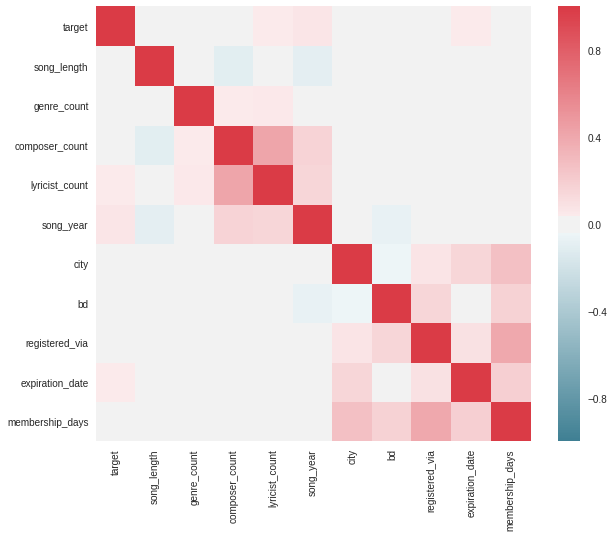

In [11]:
corr = train_df.corr()

f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
sns.plt.show()

# LGBM training

In [12]:
train_set = lgb.Dataset(x, y)
hold_out_set = lgb.Dataset(x_valid, y_valid, free_raw_data=False)
watchlist = [hold_out_set]

params = dict({
    'learning_rate': 0.2,
    'application': 'binary',
    'min_data_in_leaf': 10,
    'max_depth': 10,
    'max_bin': 255,
    'verbosity': 0,
    'metric': 'auc',
})

grid_params = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [8, 10],
}

# best_grid_params = custom_grid_search(params, grid_params, train_set, hold_out_set, num_boost_round=20)
# for key, val in best_grid_params.items():
#     params[key] = best_grid_params[key]

model = lgb.train(params, train_set=train_set, valid_sets=watchlist, num_boost_round=100, verbose_eval=5)
y_test = model.predict(x_test)

[5]	valid_0's auc: 0.687124
[10]	valid_0's auc: 0.707088
[15]	valid_0's auc: 0.721094
[20]	valid_0's auc: 0.728293
[25]	valid_0's auc: 0.732771
[30]	valid_0's auc: 0.738315
[35]	valid_0's auc: 0.741632
[40]	valid_0's auc: 0.744792
[45]	valid_0's auc: 0.747361
[50]	valid_0's auc: 0.750527
[55]	valid_0's auc: 0.754143
[60]	valid_0's auc: 0.756546
[65]	valid_0's auc: 0.758751
[70]	valid_0's auc: 0.761565
[75]	valid_0's auc: 0.763116
[80]	valid_0's auc: 0.764542
[85]	valid_0's auc: 0.765809
[90]	valid_0's auc: 0.767813
[95]	valid_0's auc: 0.769104
[100]	valid_0's auc: 0.770508


## Feature importances

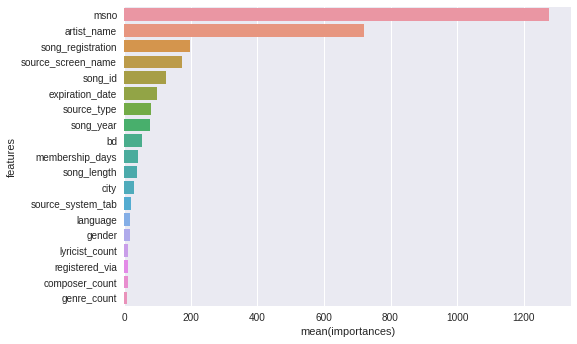

In [ ]:
plot_df = pd.DataFrame({'features': train_df.columns[train_df.columns != 'target'],
                        'importances': model.feature_importance()})
plot_df = plot_df.sort_values('importances', ascending=False)

sns.barplot(x = plot_df.importances, y = plot_df.features)
sns.plt.show()

In [ ]:
submission_df = pd.DataFrame()
submission_df['id'] = test_ids
submission_df['target'] = y_test
# string file compression reduces file size
submission_df.to_csv('data/submission.csv.gz', compression = 'gzip', index=False, float_format = '%.5f')
submission_df.info()